In [252]:
import numpy as np
import pandas as pd 
import  matplotlib.pyplot as plt
import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from feature_engine.encoding import (RareLabelEncoder,MeanEncoder, CountFrequencyEncoder)
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import ( OneHotEncoder, OrdinalEncoder, MinMaxScaler,PowerTransformer, FunctionTransformer,StandardScaler
)
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from sklearn.compose import ColumnTransformer
from sklearn.metrics.pairwise import rbf_kernel
import warnings


In [200]:
pd.set_option("display.max_columns", None)
sklearn.set_config(transform_output="pandas")
warnings.filterwarnings("ignore")

In [201]:
path = r"/Users/harsimranjitsingh/Desktop/Projects/data/train.csv"
train  = pd.read_csv(path)

In [202]:
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-03-06,Delhi,Cochin,18:15:00,19:45:00,1530,1.0,No Info,17024
1,Indigo,2019-03-09,Delhi,Cochin,04:55:00,12:00:00,425,1.0,No Info,6171
2,Air India,2019-06-15,Delhi,Cochin,13:20:00,07:40:00,1100,2.0,No Info,12121
3,Multiple Carriers,2019-03-27,Delhi,Cochin,10:20:00,01:35:00,915,1.0,No Info,6427
4,Jet Airways,2019-05-01,Kolkata,Banglore,21:10:00,04:40:00,450,1.0,In-flight meal not included,10844
...,...,...,...,...,...,...,...,...,...,...
6395,Jet Airways,2019-06-12,Kolkata,Banglore,06:30:00,16:20:00,590,1.0,In-flight meal not included,9899
6396,Indigo,2019-03-06,Delhi,Cochin,11:55:00,22:20:00,625,1.0,No Info,6442
6397,Indigo,2019-05-18,Banglore,Delhi,13:00:00,15:50:00,170,0.0,No Info,4423
6398,Air India,2019-03-06,Delhi,Cochin,07:00:00,19:15:00,735,1.0,No Info,15809


In [203]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6400 entries, 0 to 6399
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          6400 non-null   object 
 1   date_of_journey  6400 non-null   object 
 2   source           6400 non-null   object 
 3   destination      6400 non-null   object 
 4   dep_time         6400 non-null   object 
 5   arrival_time     6400 non-null   object 
 6   duration         6400 non-null   int64  
 7   total_stops      6400 non-null   float64
 8   additional_info  6400 non-null   object 
 9   price            6400 non-null   int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 500.1+ KB


In [204]:
X_train = train.drop(columns="price")
y_train = train.price.copy()

In [205]:
## Transformation operation
X_train.columns.to_list()

['airline',
 'date_of_journey',
 'source',
 'destination',
 'dep_time',
 'arrival_time',
 'duration',
 'total_stops',
 'additional_info']

In [206]:
X_train.airline

0             Jet Airways
1                  Indigo
2               Air India
3       Multiple Carriers
4             Jet Airways
              ...        
6395          Jet Airways
6396               Indigo
6397               Indigo
6398            Air India
6399            Air India
Name: airline, Length: 6400, dtype: object

In [207]:
air_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
     ])

In [208]:
air_transformer.fit_transform(X_train.loc[:, ["airline"]])

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Other
0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
6395,0.0,0.0,1.0,0.0,0.0
6396,0.0,1.0,0.0,0.0,0.0
6397,0.0,1.0,0.0,0.0,0.0
6398,1.0,0.0,0.0,0.0,0.0


In [209]:
# Date of journey

X_train.date_of_journey

0       2019-03-06
1       2019-03-09
2       2019-06-15
3       2019-03-27
4       2019-05-01
           ...    
6395    2019-06-12
6396    2019-03-06
6397    2019-05-18
6398    2019-03-06
6399    2019-05-01
Name: date_of_journey, Length: 6400, dtype: object

In [210]:
# features to extract 

features_to_extract = ["month", "week", "day_of_week", "day_of_year"]
doj_transformer   = Pipeline(steps =[
    ("dt", DatetimeFeatures(features_to_extract=features_to_extract, yearfirst=True, format="mixed")),
    ("scaler", MinMaxScaler())
])
doj_transformer.fit_transform(X_train.loc[:, ["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,0.000000,0.058824,0.333333,0.042373
1,0.000000,0.058824,0.833333,0.067797
2,1.000000,0.882353,0.833333,0.898305
3,0.000000,0.235294,0.333333,0.220339
4,0.666667,0.529412,0.333333,0.516949
...,...,...,...,...
6395,1.000000,0.882353,0.333333,0.872881
6396,0.000000,0.058824,0.333333,0.042373
6397,0.666667,0.647059,0.833333,0.661017
6398,0.000000,0.058824,0.333333,0.042373


In [211]:
# source and destinations

location_subset = X_train.loc[:, ["source", "destination"]]
location_subset

,source,destination
0,Delhi,Cochin
1,Delhi,Cochin
2,Delhi,Cochin
3,Delhi,Cochin
4,Kolkata,Banglore
...,...,...
6395,Kolkata,Banglore
6396,Delhi,Cochin
6397,Banglore,Delhi
6398,Delhi,Cochin


In [212]:
location_pipe1 = Pipeline(steps=[
    ("grouper" , RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
    ("encoder", MeanEncoder()),
    ("scaler", PowerTransformer())
])
location_pipe1.fit_transform(location_subset, y_train)

,source,destination
0,1.045202,1.040899
1,1.045202,1.040899
2,1.045202,1.040899
3,1.045202,1.040899
4,-0.196409,-0.229216
...,...,...
6395,-0.196409,-0.229216
6396,1.045202,1.040899
6397,-0.931198,-1.851147
6398,1.045202,1.040899


In [213]:
def is_north(X):
    columns = X.columns.to_list()
    north_cities = ["Delhi", "Kolkata", "Mumbai", "New Delhi"]
    return (
        X
        .assign(**{
            f"{col}_is_north" : X.loc[:, col].isin(north_cities).astype(int)
            for col in columns
        })
        .drop(columns=columns)
    )
FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
6395,1,0
6396,1,0
6397,0,1
6398,1,0


In [214]:
location_transformer = FeatureUnion(transformer_list = [
    ("part1" , location_pipe1),
    ("part2", FunctionTransformer(func=is_north))
])
location_transformer.fit_transform(location_subset, y_train)

,source,destination,source_is_north,destination_is_north
0,1.045202,1.040899,1,0
1,1.045202,1.040899,1,0
2,1.045202,1.040899,1,0
3,1.045202,1.040899,1,0
4,-0.196409,-0.229216,1,0
...,...,...,...,...
6395,-0.196409,-0.229216,1,0
6396,1.045202,1.040899,1,0
6397,-0.931198,-1.851147,0,1
6398,1.045202,1.040899,1,0


In [215]:
# departue and arrival time

X_train.arrival_time

0       19:45:00
1       12:00:00
2       07:40:00
3       01:35:00
4       04:40:00
          ...   
6395    16:20:00
6396    22:20:00
6397    15:50:00
6398    19:15:00
6399    08:55:00
Name: arrival_time, Length: 6400, dtype: object

In [216]:
time_subset = X_train.loc[:, ["dep_time", "arrival_time"]]
time_subset

,dep_time,arrival_time
0,18:15:00,19:45:00
1,04:55:00,12:00:00
2,13:20:00,07:40:00
3,10:20:00,01:35:00
4,21:10:00,04:40:00
...,...,...
6395,06:30:00,16:20:00
6396,11:55:00,22:20:00
6397,13:00:00,15:50:00
6398,07:00:00,19:15:00


In [217]:
time_pipe1 = Pipeline(steps=[
    ("dt", DatetimeFeatures(features_to_extract=["hour", "minute"])),
    ("scaler", MinMaxScaler())
])
time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.782609,0.272727,0.826087,0.818182
1,0.173913,1.000000,0.521739,0.000000
2,0.565217,0.363636,0.304348,0.727273
3,0.434783,0.363636,0.043478,0.636364
4,0.913043,0.181818,0.173913,0.727273
...,...,...,...,...
6395,0.260870,0.545455,0.695652,0.363636
6396,0.478261,1.000000,0.956522,0.363636
6397,0.565217,0.000000,0.652174,0.909091
6398,0.304348,0.000000,0.826087,0.272727


In [218]:
def part_of_day(X, morning=4, noon=12, eve=16, night=20):
	columns = X.columns.to_list()
	X_temp = X.assign(**{
		col: pd.to_datetime(X.loc[:, col]).dt.hour
		for col in columns
	})

	return (
		X_temp
		.assign(**{
			f"{col}_part_of_day": np.select(
				[X_temp.loc[:, col].between(morning, noon, inclusive="left"),
				 X_temp.loc[:, col].between(noon, eve, inclusive="left"),
				 X_temp.loc[:, col].between(eve, night, inclusive="left")],
				["morning", "afternoon", "evening"],
				default="night"
			)
			for col in columns
		})
		.drop(columns=columns)
	)

FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,evening,evening
1,morning,afternoon
2,afternoon,morning
3,morning,night
4,night,morning
...,...,...
6395,morning,evening
6396,morning,night
6397,afternoon,afternoon
6398,morning,evening


In [219]:
time_pipe2  = Pipeline(steps=[
    ("part", FunctionTransformer(func=part_of_day)),
    ("encoder", CountFrequencyEncoder()),
    ("scaler", MinMaxScaler())
])
time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,0.181776,0.639495
1,1.000000,0.000000
2,0.000000,0.923077
3,1.000000,1.000000
4,0.156542,0.923077
...,...,...
6395,1.000000,0.639495
6396,1.000000,1.000000
6397,0.000000,0.000000
6398,1.000000,0.639495


In [220]:
time_transformer= FeatureUnion(transformer_list=[
    ("part1", time_pipe1), 
    ("part2", time_pipe2)
])
time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.782609,0.272727,0.826087,0.818182,0.181776,0.639495
1,0.173913,1.000000,0.521739,0.000000,1.000000,0.000000
2,0.565217,0.363636,0.304348,0.727273,0.000000,0.923077
3,0.434783,0.363636,0.043478,0.636364,1.000000,1.000000
4,0.913043,0.181818,0.173913,0.727273,0.156542,0.923077
...,...,...,...,...,...,...
6395,0.260870,0.545455,0.695652,0.363636,1.000000,0.639495
6396,0.478261,1.000000,0.956522,0.363636,1.000000,1.000000
6397,0.565217,0.000000,0.652174,0.909091,0.000000,0.000000
6398,0.304348,0.000000,0.826087,0.272727,1.000000,0.639495


In [221]:
#duration
X_train.duration

0       1530
1        425
2       1100
3        915
4        450
        ... 
6395     590
6396     625
6397     170
6398     735
6399    1385
Name: duration, Length: 6400, dtype: int64

In [222]:
def duration_category(X, short=180, med=400):
	return (
		X
		.assign(duration_cat=np.select([X.duration.lt(short),
									    X.duration.between(short, med, inclusive="left")],
									   ["short", "medium"],
									   default="long"))
		.drop(columns="duration")
	)

In [223]:
def is_over(X, value=1000):
	return (
		X
		.assign(**{
			f"duration_over_{value}": X.duration.ge(value).astype(int)
		})
		.drop(columns="duration")
	)

In [224]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
	def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
		self.variables = variables
		self.percentiles = percentiles
		self.gamma = gamma


	def fit(self, X, y=None):
		if not self.variables:
			self.variables = X.select_dtypes(include="number").columns.to_list()

		self.reference_values_ = {
			col: (
				X
				.loc[:, col]
				.quantile(self.percentiles)
				.values
				.reshape(-1, 1)
			)
			for col in self.variables
		}

		return self


	def transform(self, X):
		objects = []
		for col in self.variables:
			columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
			obj = pd.DataFrame(
				data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
				columns=columns
			)
			objects.append(obj)
		return pd.concat(objects, axis=1)
            

In [225]:

RBFPercentileSimilarity(percentiles=[0.4, 0.8]).fit_transform(X_train)

,duration_rbf_40,duration_rbf_80,total_stops_rbf_40,total_stops_rbf_80
0,0.000000e+00,0.000000e+00,1.000000,1.000000
1,3.240271e-184,0.000000e+00,1.000000,1.000000
2,0.000000e+00,6.293989e-54,0.904837,0.904837
3,0.000000e+00,0.000000e+00,1.000000,1.000000
4,0.000000e+00,0.000000e+00,1.000000,1.000000
...,...,...,...,...
6395,0.000000e+00,0.000000e+00,1.000000,1.000000
6396,0.000000e+00,0.000000e+00,1.000000,1.000000
6397,0.000000e+00,0.000000e+00,0.904837,0.904837
6398,0.000000e+00,0.000000e+00,1.000000,1.000000


In [226]:
(
    X_train
    .duration
    .quantile([0.25, 0.5, 0.75])
    .values
    .reshape(-1, 1)
    # .shape
)

array([[170.],
       [505.],
       [910.]])

In [230]:
duration_pipe1 = Pipeline(steps=[
	("rbf", RBFPercentileSimilarity()),
	("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
	("cat", FunctionTransformer(func=duration_category)),
	("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])
duration_union = FeatureUnion(transformer_list=[
	("part1", duration_pipe1),
	("part2", duration_pipe2),
	("part3", FunctionTransformer(func=is_over)),
	("part4", StandardScaler())
])
duration_transformer = Pipeline(steps=[
	("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
	("imputer", SimpleImputer(strategy="median")),
	("union", duration_union)
])

duration_transformer.fit_transform(X_train.loc[:, ["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.360707,-0.116418,-0.075580,2.0,1,1.817708
1,-0.360707,-0.116418,-0.075580,2.0,0,-0.414382
2,-0.360707,-0.116418,-0.075580,2.0,1,0.949112
3,-0.360707,-0.116418,13.483305,2.0,0,0.575413
4,-0.360707,-0.116418,-0.075580,2.0,0,-0.363882
...,...,...,...,...,...,...
6395,-0.360707,-0.116418,-0.075580,2.0,0,-0.081084
6396,-0.360707,-0.116418,-0.075580,2.0,0,-0.010384
6397,3.130270,-0.116418,-0.075580,0.0,0,-0.929480
6398,-0.360707,-0.116418,-0.075580,2.0,0,0.211815


In [234]:
# total Stops 
def is_direct(X):
	return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))


total_stops_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:, ["total_stops"]])


,total_stops,is_direct_flight
0,1.0,0
1,1.0,0
2,2.0,0
3,1.0,0
4,1.0,0
...,...,...
6395,1.0,0
6396,1.0,0
6397,0.0,1
6398,1.0,0


In [236]:
# additional_info

info_pipe1 = Pipeline(steps=[
	("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
	("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,1.0,0.0,0.0
...,...,...,...
6395,1.0,0.0,0.0
6396,0.0,1.0,0.0
6397,0.0,1.0,0.0
6398,0.0,1.0,0.0


In [238]:
def have_info(X):
	return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))
    

In [239]:
info_union = FeatureUnion(transformer_list=[
	("part1", info_pipe1),
	("part2", FunctionTransformer(func=have_info))
])

In [240]:

info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

info_transformer.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,0.0,1.0,0.0,0
1,0.0,1.0,0.0,0
2,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0
4,1.0,0.0,0.0,1
...,...,...,...,...
6395,1.0,0.0,0.0,1
6396,0.0,1.0,0.0,0
6397,0.0,1.0,0.0,0
6398,0.0,1.0,0.0,0


In [241]:
column_transformer = ColumnTransformer(transformers=[
    ("air", air_transformer, ["airline"]),
    ("doj", doj_transformer, ["date_of_journey"]),
    ("location", location_transformer, ["source", "destination"]),
    ("time", time_transformer, ["dep_time", "arrival_time"]),
    ("dur", duration_transformer, ["duration"]),
    ("stops", total_stops_transformer, ["total_stops"]),
	("info", info_transformer, ["additional_info"])
], 
remainder="passthrough")

column_transformer.fit_transform(X_train, y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_Other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,0.0,0.0,1.0,0.0,0.0,0.000000,0.058824,0.333333,0.042373,1.045202,1.040899,1,0,0.782609,0.272727,0.826087,0.818182,0.181776,0.639495,-0.360707,-0.116418,-0.075580,2.0,1,1.817708,1.0,0,0.0,1.0,0.0,0
1,0.0,1.0,0.0,0.0,0.0,0.000000,0.058824,0.833333,0.067797,1.045202,1.040899,1,0,0.173913,1.000000,0.521739,0.000000,1.000000,0.000000,-0.360707,-0.116418,-0.075580,2.0,0,-0.414382,1.0,0,0.0,1.0,0.0,0
2,1.0,0.0,0.0,0.0,0.0,1.000000,0.882353,0.833333,0.898305,1.045202,1.040899,1,0,0.565217,0.363636,0.304348,0.727273,0.000000,0.923077,-0.360707,-0.116418,-0.075580,2.0,1,0.949112,2.0,0,0.0,1.0,0.0,0
3,0.0,0.0,0.0,1.0,0.0,0.000000,0.235294,0.333333,0.220339,1.045202,1.040899,1,0,0.434783,0.363636,0.043478,0.636364,1.000000,1.000000,-0.360707,-0.116418,13.483305,2.0,0,0.575413,1.0,0,0.0,1.0,0.0,0
4,0.0,0.0,1.0,0.0,0.0,0.666667,0.529412,0.333333,0.516949,-0.196409,-0.229216,1,0,0.913043,0.181818,0.173913,0.727273,0.156542,0.923077,-0.360707,-0.116418,-0.075580,2.0,0,-0.363882,1.0,0,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6395,0.0,0.0,1.0,0.0,0.0,1.000000,0.882353,0.333333,0.872881,-0.196409,-0.229216,1,0,0.260870,0.545455,0.695652,0.363636,1.000000,0.639495,-0.360707,-0.116418,-0.075580,2.0,0,-0.081084,1.0,0,1.0,0.0,0.0,1
6396,0.0,1.0,0.0,0.0,0.0,0.000000,0.058824,0.333333,0.042373,1.045202,1.040899,1,0,0.478261,1.000000,0.956522,0.363636,1.000000,1.000000,-0.360707,-0.116418,-0.075580,2.0,0,-0.010384,1.0,0,0.0,1.0,0.0,0
6397,0.0,1.0,0.0,0.0,0.0,0.666667,0.647059,0.833333,0.661017,-0.931198,-1.851147,0,1,0.565217,0.000000,0.652174,0.909091,0.000000,0.000000,3.130270,-0.116418,-0.075580,0.0,0,-0.929480,0.0,1,0.0,1.0,0.0,0
6398,1.0,0.0,0.0,0.0,0.0,0.000000,0.058824,0.333333,0.042373,1.045202,1.040899,1,0,0.304348,0.000000,0.826087,0.272727,1.000000,0.639495,-0.360707,-0.116418,-0.075580,2.0,0,0.211815,1.0,0,0.0,1.0,0.0,0


In [244]:
# Feature_selection
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
) 

In [246]:
preprocessor = Pipeline(steps=[
	("ct", column_transformer),
	("selector", selector)
])

preprocessor.fit_transform(X_train, y_train)

,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_rbf_25,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight
0,0.0,1.0,0.0,0.058824,0.042373,1.045202,1.040899,-0.360707,2.0,1,1.817708,1.0,0
1,1.0,0.0,0.0,0.058824,0.067797,1.045202,1.040899,-0.360707,2.0,0,-0.414382,1.0,0
2,0.0,0.0,0.0,0.882353,0.898305,1.045202,1.040899,-0.360707,2.0,1,0.949112,2.0,0
3,0.0,0.0,0.0,0.235294,0.220339,1.045202,1.040899,-0.360707,2.0,0,0.575413,1.0,0
4,0.0,1.0,0.0,0.529412,0.516949,-0.196409,-0.229216,-0.360707,2.0,0,-0.363882,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6395,0.0,1.0,0.0,0.882353,0.872881,-0.196409,-0.229216,-0.360707,2.0,0,-0.081084,1.0,0
6396,1.0,0.0,0.0,0.058824,0.042373,1.045202,1.040899,-0.360707,2.0,0,-0.010384,1.0,0
6397,1.0,0.0,0.0,0.647059,0.661017,-0.931198,-1.851147,3.130270,0.0,0,-0.929480,0.0,1
6398,0.0,0.0,0.0,0.058824,0.042373,1.045202,1.040899,-0.360707,2.0,0,0.211815,1.0,0


In [247]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': 0.0014781967834464431,
 'air__airline_Indigo': 0.12503399565425,
 'air__airline_Jet Airways': 0.1793319613429359,
 'air__airline_Multiple Carriers': 0.019451559756238395,
 'air__airline_Other': 0.11360406161888352,
 'doj__date_of_journey_month': 0.09247186066625561,
 'doj__date_of_journey_week': 0.191334042011424,
 'doj__date_of_journey_day_of_week': 0.005721939696044842,
 'doj__date_of_journey_day_of_year': 0.24004011067571338,
 'location__source': 0.12172308975797526,
 'location__destination': 0.12795845980392764,
 'location__source_is_north': 0.03115524963935934,
 'location__destination_is_north': 0.03115524963935934,
 'time__dep_time_hour': 0.011407691615759793,
 'time__dep_time_minute': 0.037479286085634556,
 'time__arrival_time_hour': 0.06182514686735896,
 'time__arrival_time_minute': 0.038562952569333696,
 'time__dep_time_part_of_day': -0.000564106295273592,
 'time__arrival_time_part_of_day': 0.024888596428739047,
 'dur__duration_rbf_25': 0.11459739109

In [249]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp


{'time__dep_time_part_of_day': -0.000564106295273592,
 'info__additional_info_No Info': -5.4425210585999174e-05,
 'info__additional_info': -5.4425210585999174e-05,
 'dur__duration_rbf_75': 0.0006309517664802774,
 'info__additional_info_In-flight meal not included': 0.0010679866721436577,
 'air__airline_Air India': 0.0014781967834464431,
 'dur__duration_rbf_50': 0.004714869324290734,
 'doj__date_of_journey_day_of_week': 0.005721939696044842,
 'time__dep_time_hour': 0.011407691615759793,
 'info__additional_info_Other': 0.01653762610335263,
 'air__airline_Multiple Carriers': 0.019451559756238395,
 'time__arrival_time_part_of_day': 0.024888596428739047,
 'location__source_is_north': 0.03115524963935934,
 'location__destination_is_north': 0.03115524963935934,
 'time__dep_time_minute': 0.037479286085634556,
 'time__arrival_time_minute': 0.038562952569333696,
 'time__arrival_time_hour': 0.06182514686735896,
 'doj__date_of_journey_month': 0.09247186066625561,
 'dur__duration_over_1000': 0.1011

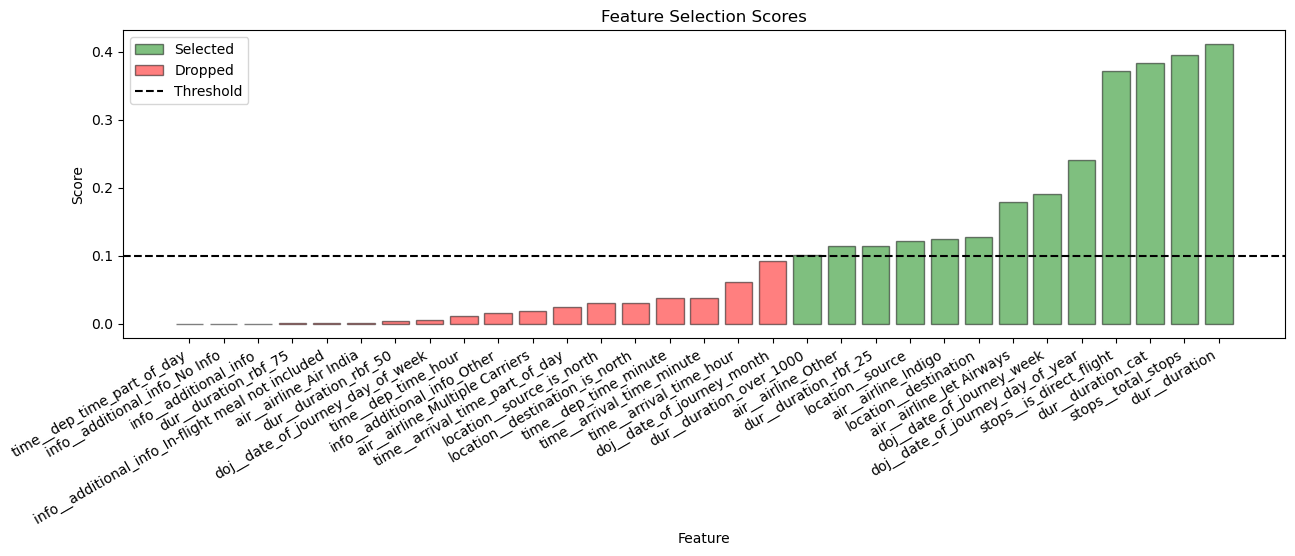

In [253]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()